In [1]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_times(path):
    with open(path) as fd:
        results = json.load(fd)['results']
    return {r['command']: np.array(r['times']) for r in results}

This notebook should only be run after running `make` on a system with some provision for benchmarking, i.e. nothing else going on CPU, frequency scaling disabled.

Note that the Makefile disables the running via the shell (`-N`) and sets a relatively long warm-up.  Both were needed to get reliable timings for me.

The lines of printed output are 16%, 50%, and 84% quantiles; i.e. median and those associated with one standard deviation. and are followed by the command line.  The program takes a single optional parameter which describes how many times to print hello world.  Not passing this argument causes it to default to 1 and hence ensure that the command line parsing isn't affecting things.

## outcomes

The actual printing doesn't take any significant amount of time in comparison to getting the program running.  Basically all the time is spent in the dynamic linker, as can be seen by the difference in time between not printing anything (i.e. passing `0` and printing "hello world" 1000 times).

The fully static builds of C and C++ code have almost the same runtime which is nice.

0.243 0.247 0.255 ./hello_c 
0.225 0.236 0.249 ./hello_c 0
0.236 0.249 0.287 ./hello_c 1
0.268 0.272 0.278 ./hello_c 1000
0.147 0.150 0.154 ./hello_c_static 
0.146 0.147 0.151 ./hello_c_static 0
0.147 0.148 0.153 ./hello_c_static 1
0.167 0.168 0.174 ./hello_c_static 1000
0.792 0.834 0.860 ./hello_cpp 
0.796 0.822 0.853 ./hello_cpp 0
0.778 0.801 0.841 ./hello_cpp 1
0.813 0.832 0.866 ./hello_cpp 1000
0.371 0.433 0.460 ./hello_static_cpp 
0.366 0.386 0.450 ./hello_static_cpp 0
0.426 0.452 0.467 ./hello_static_cpp 1
0.418 0.465 0.496 ./hello_static_cpp 1000
0.194 0.196 0.199 ./hello_cpp_full_static 
0.191 0.193 0.198 ./hello_cpp_full_static 0
0.195 0.196 0.200 ./hello_cpp_full_static 1
0.220 0.222 0.227 ./hello_cpp_full_static 1000


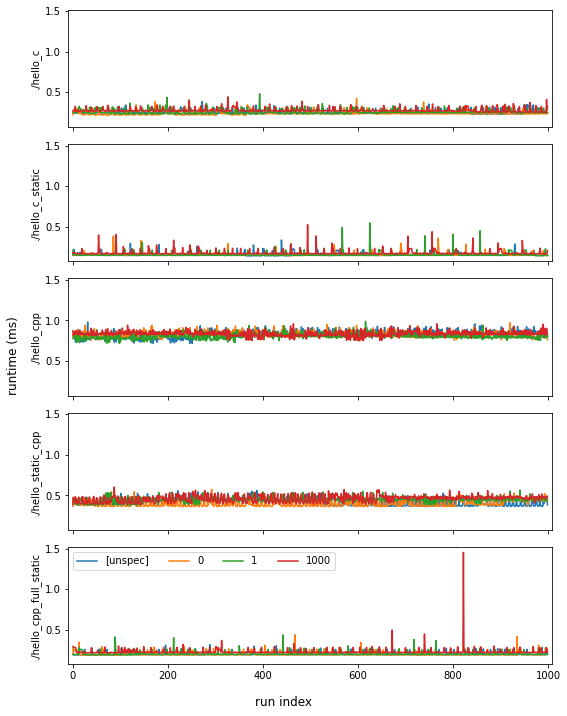

In [3]:
progs = 'hello_c hello_c_static hello_cpp hello_static_cpp hello_cpp_full_static'.split()

fig, axs = plt.subplots(nrows=len(progs), figsize=(8, 10), sharex=True, sharey=True)

for prog, ax in zip(progs, axs):
    data = load_times(f'{prog}.json')

    for command, times in data.items():
        [cmd, extra] = command.split(' ', 1)
        if not extra:
            extra = '[unspec]'
        ax.plot(times * 1000, label=extra)
    
        qs = np.quantile(times * 1000, [0.16, 0.5, 0.84])
        print(*(f'{v:.3f}' for v in qs), command)

    ax.set_ylabel(cmd)
    ax.margins(x=0.01)

# legends are all the same, not point showing them every time
ax.legend(loc='upper left', ncol=4)

fig.supxlabel("run index")
fig.supylabel("runtime (ms)")
fig.tight_layout()

Run a few under `strace` to get an idea of what's going on behind the scenes.  It also shows that all these flushes that a lot of commenters seem to be worried about aren't actually an issue.

In [4]:
!strace ./hello_c

execve("./hello_c", ["./hello_c"], 0x7fff0bb27d60 /* 42 vars */) = 0
brk(NULL)                               = 0x55a3ecc56000
arch_prctl(0x3001 /* ARCH_??? */, 0x7ffda493e3c0) = -1 EINVAL (Invalid argument)
mmap(NULL, 8192, PROT_READ|PROT_WRITE, MAP_PRIVATE|MAP_ANONYMOUS, -1, 0) = 0x7f484e27a000
access("/etc/ld.so.preload", R_OK)      = -1 ENOENT (No such file or directory)
openat(AT_FDCWD, "/etc/ld.so.cache", O_RDONLY|O_CLOEXEC) = 3
newfstatat(3, "", {st_mode=S_IFREG|0644, st_size=192471, ...}, AT_EMPTY_PATH) = 0
mmap(NULL, 192471, PROT_READ, MAP_PRIVATE, 3, 0) = 0x7f484e24b000
close(3)                                = 0
openat(AT_FDCWD, "/usr/lib/libc.so.6", O_RDONLY|O_CLOEXEC) = 3
read(3, "\177ELF\2\1\1\3\0\0\0\0\0\0\0\0\3\0>\0\1\0\0\0\2204\2\0\0\0\0\0"..., 832) = 832
pread64(3, "\6\0\0\0\4\0\0\0@\0\0\0\0\0\0\0@\0\0\0\0\0\0\0@\0\0\0\0\0\0\0"..., 784, 64) = 784
newfstatat(3, "", {st_mode=S_IFREG|0755, st_size=1936696, ...}, AT_EMPTY_PATH) = 0
pread64(3, "\6\0\0\0\4\0\0\0@\0\0\0\0\0\0

In [5]:
!strace ./hello_c_static 5

execve("./hello_c_static", ["./hello_c_static", "5"], 0x7fff67a826e8 /* 42 vars */) = 0
arch_prctl(0x3001 /* ARCH_??? */, 0x7ffed1970ac0) = -1 EINVAL (Invalid argument)
brk(NULL)                               = 0xf0d000
brk(0xf0dd00)                           = 0xf0dd00
arch_prctl(ARCH_SET_FS, 0xf0d380)       = 0
set_tid_address(0xf0d650)               = 632509
set_robust_list(0xf0d660, 24)           = 0
rseq(0xf0dca0, 0x20, 0, 0x53053053)     = 0
prlimit64(0, RLIMIT_STACK, NULL, {rlim_cur=8192*1024, rlim_max=RLIM64_INFINITY}) = 0
readlink("/proc/self/exe", "/home/smason/self/lemire-hello/h"..., 4096) = 45
getrandom("\x8c\x09\x41\xb4\x07\xc6\xff\x0e", 8, GRND_NONBLOCK) = 8
brk(NULL)                               = 0xf0dd00
brk(0xf2ed00)                           = 0xf2ed00
brk(0xf2f000)                           = 0xf2f000
mprotect(0x4a3000, 16384, PROT_READ)    = 0
newfstatat(1, "", {st_mode=S_IFCHR|0620, st_rdev=makedev(0x88, 0x2), ...}, AT_EMPTY_PATH) = 0
write(1, "hello world\n", 1

In [6]:
!strace ./hello_cpp

execve("./hello_cpp", ["./hello_cpp"], 0x7ffc897489f0 /* 42 vars */) = 0
brk(NULL)                               = 0x555986580000
arch_prctl(0x3001 /* ARCH_??? */, 0x7ffd9f4d23b0) = -1 EINVAL (Invalid argument)
mmap(NULL, 8192, PROT_READ|PROT_WRITE, MAP_PRIVATE|MAP_ANONYMOUS, -1, 0) = 0x7feeab882000
access("/etc/ld.so.preload", R_OK)      = -1 ENOENT (No such file or directory)
openat(AT_FDCWD, "/etc/ld.so.cache", O_RDONLY|O_CLOEXEC) = 3
newfstatat(3, "", {st_mode=S_IFREG|0644, st_size=192471, ...}, AT_EMPTY_PATH) = 0
mmap(NULL, 192471, PROT_READ, MAP_PRIVATE, 3, 0) = 0x7feeab853000
close(3)                                = 0
openat(AT_FDCWD, "/usr/lib/libstdc++.so.6", O_RDONLY|O_CLOEXEC) = 3
read(3, "\177ELF\2\1\1\3\0\0\0\0\0\0\0\0\3\0>\0\1\0\0\0\0\0\0\0\0\0\0\0"..., 832) = 832
newfstatat(3, "", {st_mode=S_IFREG|0755, st_size=19202160, ...}, AT_EMPTY_PATH) = 0
mmap(NULL, 2320384, PROT_READ, MAP_PRIVATE|MAP_DENYWRITE, 3, 0) = 0x7feeab600000
mmap(0x7feeab699000, 1138688, PROT_READ|PROT_

In [7]:
!strace ./hello_cpp_full_static 5

execve("./hello_cpp_full_static", ["./hello_cpp_full_static", "5"], 0x7ffea82d0de8 /* 42 vars */) = 0
arch_prctl(0x3001 /* ARCH_??? */, 0x7ffcc9659210) = -1 EINVAL (Invalid argument)
brk(NULL)                               = 0x1af3000
brk(0x1af3d80)                          = 0x1af3d80
arch_prctl(ARCH_SET_FS, 0x1af3400)      = 0
set_tid_address(0x1af36d0)              = 632531
set_robust_list(0x1af36e0, 24)          = 0
rseq(0x1af3d20, 0x20, 0, 0x53053053)    = 0
prlimit64(0, RLIMIT_STACK, NULL, {rlim_cur=8192*1024, rlim_max=RLIM64_INFINITY}) = 0
readlink("/proc/self/exe", "/home/smason/self/lemire-hello/h"..., 4096) = 52
getrandom("\xe0\x8f\x3d\xc1\x68\x99\x4f\xc8", 8, GRND_NONBLOCK) = 8
brk(NULL)                               = 0x1af3d80
brk(0x1b14d80)                          = 0x1b14d80
brk(0x1b15000)                          = 0x1b15000
mprotect(0x5b7000, 45056, PROT_READ)    = 0
futex(0x5c565c, FUTEX_WAKE_PRIVATE, 2147483647) = 0
newfstatat(1, "", {st_mode=S_IFCHR|0620, st_rdev=m